In [1]:
import tensorflow as tf
import tensorflow_hub as hub
# for downloading and displaying image
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
# for dataframe
import pandas as pd
# for drawing onto the image
import numpy as np
from PIL import Image,ImageColor,ImageDraw,ImageFont,ImageOps
import time

In [2]:
def disp_ima(image):
    fig = plt.figure(figsize=(18, 13))
    plt.grid(False)
    plt.imshow(image) 


def get_and_reshape_img(url, width=250, height=250, display=False):
    ruff, name = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_ima = Image.open(image_data)
    pil_ima = ImageOps.fit(pil_ima, (width, height), Image.ANTIALIAS)
    pil_ima_rgb = pil_ima.convert("RGB")
    pil_ima_rgb.save(name, format="JPEG", quality=90)
    print("Image downloaded to %s." % name)
    if display:
        disp_ima(pil_ima)
    return name 


def boxes_on_image(image,ymin,xmin,ymax,xmax,color,font,thickness=4,display_str_list=()):
    draw = ImageDraw.Draw(image)
    width, height = image.size
    (left, right, top, bottom) = (xmin * width, xmax * width,
                                    ymin * height, ymax * height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
                (left, top)],
                width=thickness,
                fill=color)
    display_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_height = (1 + 2 * 0.05) * sum(display_heights)
    if top > total_height:
        text_bottom = top
    else:
        text_bottom = top + total_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                    fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                display_str,
                fill="black",
                font=font)
        text_bottom -= text_height - 2 * margin 


def drawing_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                            int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            boxes_on_image(image_pil,ymin,xmin,ymax,xmax,color,font,display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

In [19]:
def load_image(path):
    imgage_path = tf.io.read_file(path)
    imgage_path = tf.image.decode_jpeg(imgage_path, channels=3)
    return imgage_path


def run_model(model, path):
    img = load_image(path)
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start = time.time()
    result = model(converted_img)
    
    end = time.time()
    result = {key:value.numpy() for key,value in enumerate(result, 1)}
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end-start)
    image_with_boxes = drawing_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"])
    disp_ima(image_with_boxes) 

In [4]:
# img_url= "http://1.bp.blogspot.com/-nn23fvzDZBw/T_HTlRZYJuI/AAAAAAAAA5U/wHSWnIySyww/s1600/best+cool+nice+cute+awesome+desktop+background+wallpapers+%252817%2529.jpg"

# web_img = get_and_reshape_img(img_url, 1250, 850, True) 


In [7]:
module= "../models/fruitNet/fruitnet_model.h5" 

model = tf.keras.models.load_model(module,custom_objects={'KerasLayer':hub.KerasLayer})

In [8]:
def get_image(img_path, width=250, height=250, display=False):
    ruff, name = tempfile.mkstemp(suffix=".jpg")
    
    pil_ima = Image.open(img_path)
    pil_ima = ImageOps.fit(pil_ima, (width, height), Image.ANTIALIAS)
    pil_ima_rgb = pil_ima.convert("RGB")
    pil_ima_rgb.save(name, format="JPEG", quality=90)
    if display:
        disp_ima(pil_ima)
    return name 

d:\Dev\tools\envs\tf\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  """


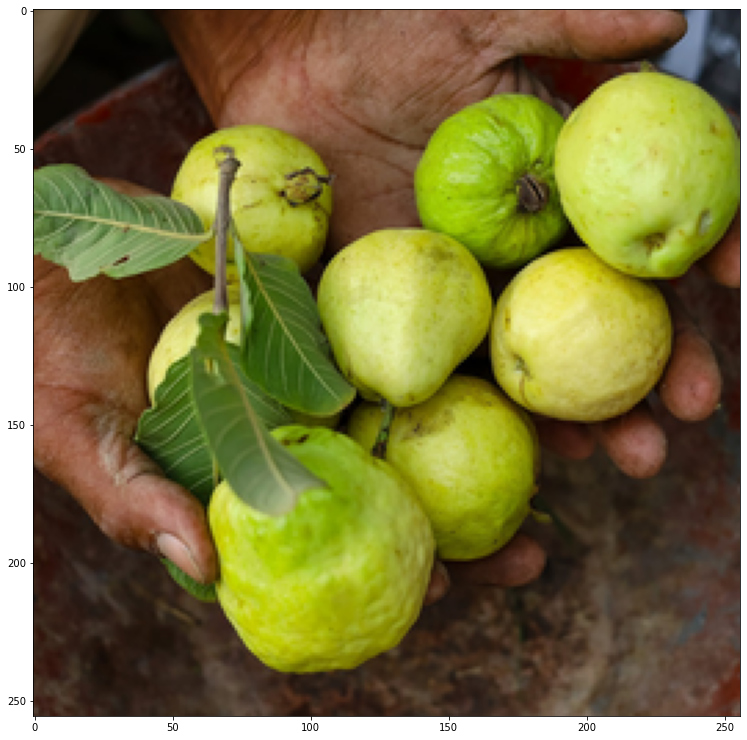

In [9]:
img = get_image("../data/fruitNet/tests/12.jpg", 256, 256, True)

In [20]:
run_model(model, img)



ValueError: too many values to unpack (expected 2)

In [18]:
ex = {"1": "Apple", "2": "Banana", "3": "Orange", "4": "Strawberry", "5": "Watermelon"}

a = [[2.3315516e-12]]
a.numpy()

AttributeError: 'list' object has no attribute 'numpy'